# Exercise 6 | Robust MPC



## Problem 1 | Robust Invariant Set

Design a robust MPC controller for the following linear system:

$$x^+ = Ax + Bu + w,  A=\begin{bmatrix}1 & 1 \\ 0 & 1\end{bmatrix}, B=\begin{bmatrix}1 \\ 0.5\end{bmatrix} $$

with constraints and bounded disturbance

$$\mathcal{X} = \{x \mid \|x\|_{\infty} \leq 3 \}, \quad \mathcal{U} = \{u \mid ~\|u\|_{\infty} \leq 0.5 \} \quad \mathcal{W} = \{w \mid \|w\|_{\infty} \leq 0.1 \} $$

The matrix $K$ is the LQR gain with $Q=I$ and $R=10$.



In [1]:
import numpy as np
from mpt4py import Polyhedron
from control import dlqr

A = np.array([[1, 1], [0, 1]])
B = np.array([[1], [0.5]])
Q = np.eye(2)
R = 10 * np.eye(1)

K, Qf, _ = dlqr(A, B, Q, R)
K = -K
A_cl = A + B @ K

x_max = 3.
u_max = 0.5
w_max = 0.1

X = Polyhedron.from_Hrep(A=np.vstack((np.eye(2), -np.eye(2))), b=x_max*np.ones(4))
U = Polyhedron.from_Hrep(A=np.vstack((np.eye(1), -np.eye(1))), b=u_max*np.ones(2))
W = Polyhedron.from_Hrep(A=np.vstack((np.eye(2), -np.eye(2))), b=w_max*np.ones(4))

### Task 1
Implement a function to compute the robust pre-set operator $\text{pre}^{\mathcal{W}}(\cdot)$


In [2]:
def robust_pre_set(A_cl: np.ndarray, Omega: Polyhedron, W: Polyhedron) -> Polyhedron:
	"""
	Compute the robust pre-set of the polytopic set Omega under the 
	autonomous LTI system x^+ = A_cl * x and polytopic disturbance set W.
	"""
	# TODO: ------------------
	# TODO: add your code here
	b_pre = Omega.b.copy()
	for i in range(Omega.b.shape[0]):
		b_pre[i] -= W.support(Omega.A[i,:])
	pre_Omega = Polyhedron.from_Hrep(A=Omega.A @ A_cl, b=b_pre)
	# TODO: ------------------
	return pre_Omega

### Task 2
Implement a function to compute the maximal robust invariant set $\mathcal{X}_f^{\mathcal{W}}$ for the above system. Use it to compute the maximal robust invariant set for the system mentioned above.

Also compute the nominal maximal invariant set $\mathcal{X}_f$ using your code from previous exercises. 

Which set do you expect to be larger? Plot both sets and compare.

**Hints**: The algorithm to compute maximal robust invariant set is summarized in the following steps. This is indeed the same algorithm as computing maximal invariant set for nominal MPC. The only difference is the pre-set operator $\text{pre}(\Omega_i)$ is replaced by the robust pre set operator $\text{pre}^\mathcal{W}(\Omega_i)$. 

$$
\begin{array}{l}
	\Omega_0 \gets \mathcal{X} \\
	\textbf{loop} \\
	\quad \Omega_{i+1} \gets \text{pre}^\mathcal{W}(\Omega_i) \cap \Omega_i \\
	\quad \textbf{if} ~ \Omega_{i+1} == \textbf{pre}^\mathcal{W} (\Omega_i) \\
	\quad\quad \textbf{return} ~ \Omega_{\infty}^\mathcal{W} = \Omega_{i} \\
	\quad \textbf{end if} \\
	\textbf{end loop}
\end{array}
$$


In [3]:
def max_robust_invariant_set(A_cl: np.ndarray, Omega: Polyhedron, W: Polyhedron, max_iter: int = 50) -> Polyhedron:
	"""
	Compute the maximal robust positive invariant set of the polytopic set Omega
	under the autonomous LTI system x^+ = A_cl * x.
	"""
	# TODO: ------------------
	# TODO: add your code here
	iter = 0
	Omega_inf = Polyhedron.from_Hrep(A=Omega.A, b=Omega.b)

	while iter < max_iter:
		iter += 1
		Omega_inf_pre = robust_pre_set(A_cl, Omega_inf, W)
		Omega_inf_next = Omega_inf.intersect(Omega_inf_pre)

		if Omega_inf_next == Omega_inf:
			print('Maximal robust invariant set computation converged after {0} iterations.'.format(iter))
			break

		if iter == max_iter:
			print('Maximal robust invariant set computation reached maximum number of iterations ({0}).'.format(iter))
			break

		Omega_inf = Omega_inf_next

	return Omega_inf
	# TODO: ------------------

In [4]:
def max_invariant_set(A_cl, X: Polyhedron, max_iter = 30) -> Polyhedron:
	"""
	Compute invariant set for an autonomous linear time invariant system x^+ = A_cl x
	"""
	# TODO: ------------------
	# TODO: add your code here
	O = X
	iter = 1
	converged = False

	while iter < max_iter:
		Oprev = O
		F, f = O.A, O.b
		O = Polyhedron.from_Hrep(A=np.vstack((F, F @ A_cl)), b=np.vstack((f, f)).reshape((-1,)))
		if O == Oprev:
			converged = True
			break
		iter += 1

	if converged:
		print('Maximum invariant set successfully computed after {0} iterations.'.format(iter))
		return O
	# TODO: ------------------

Maximum invariant set successfully computed after 3 iterations.
Maximal robust invariant set computation converged after 5 iterations.


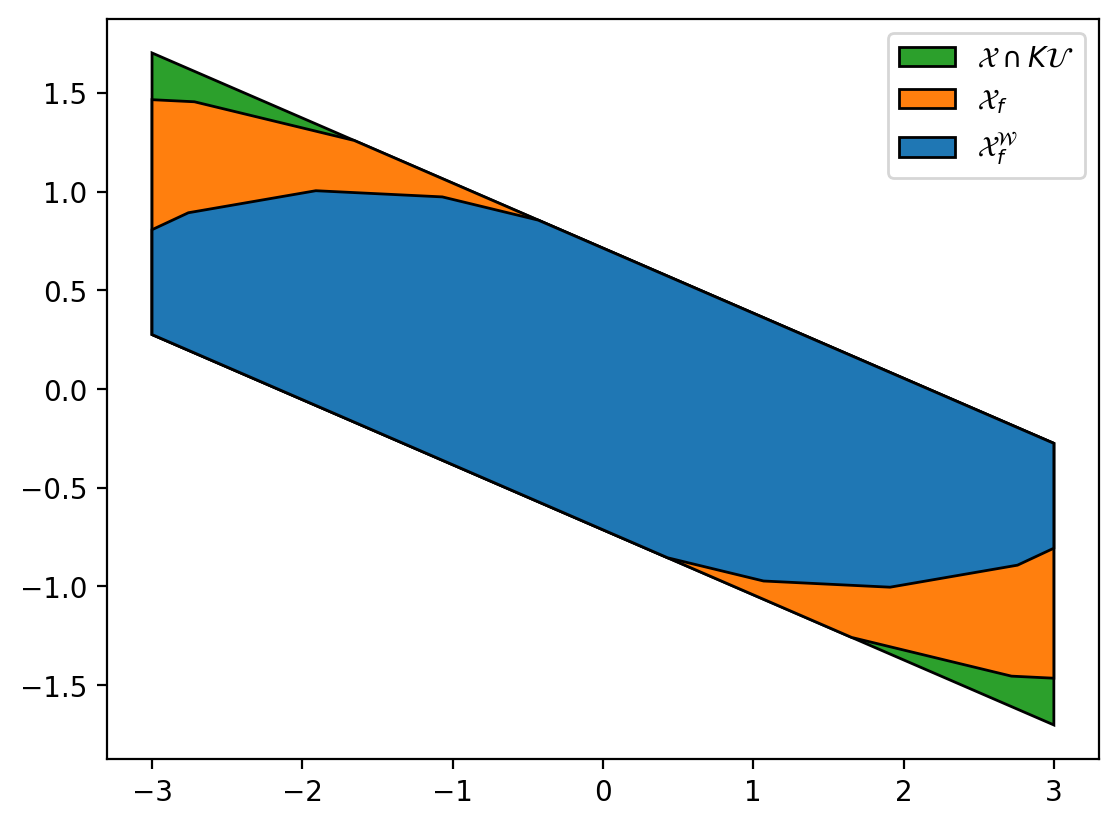

In [5]:
X_and_KU = X.intersect(Polyhedron.from_Hrep(U.A@K, U.b))
Xf = max_invariant_set(A_cl, X_and_KU)
Xf_W = max_robust_invariant_set(A_cl, X_and_KU, W)


# Plot the sets
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(1, 1)
X_and_KU.plot(ax, color='tab:green', opacity=1., label=r'$\mathcal{X}\cap K\mathcal{U}$')
Xf.plot(ax, color='tab:orange', opacity=1., label=r'$\mathcal{X}_f$')
Xf_W.plot(ax, color='tab:blue', opacity=1., label=r'$\mathcal{X}^\mathcal{W}_f$')
plt.legend()
plt.show()

### Task 3

Plot several trajectories under bounded disturbance $w_i\in\mathcal{W}$ starting from various $x_0\in\mathcal{X}_f^{\mathcal{W}} $. Show that the entire trajectory $\{x_i\}$ remains within $\mathcal{X}_f^{\mathcal{W}}$.

**Hints:** in *mpt4py*, you can uniformly sample $m$ points from a polyhedron $P\subset \mathbb{R}^n$ with `x_sampled = P.sample(m)`, where `x_sample` is a NumPy array with shape `(m, n)`.

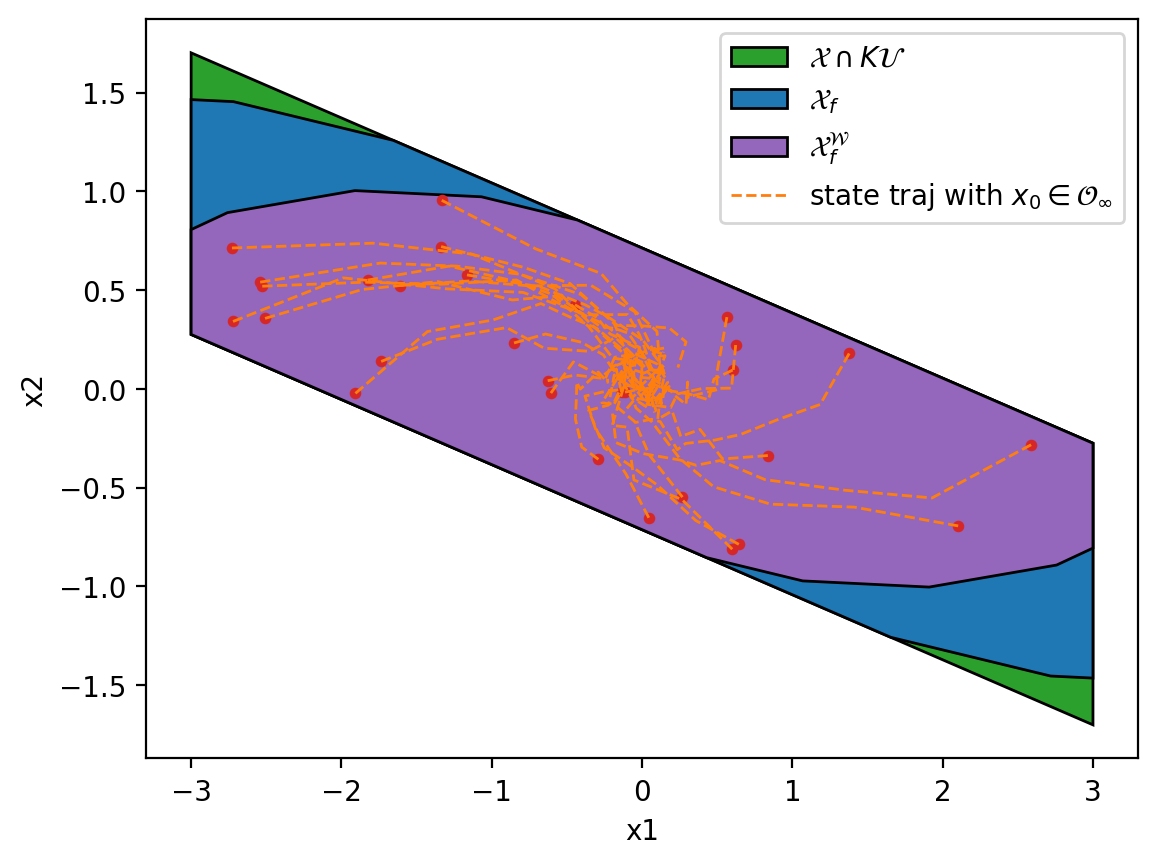

In [8]:
num_samples = 30
x0_samples = Xf_W.sample(num_samples)  # ndarray with shape (num_samples, 2)
N_sim = 10  # simulation steps

# Plot the sets
fig, ax = plt.subplots(1, 1)
X_and_KU.plot(ax, color='tab:green', opacity=1., label=r'$\mathcal{X}\cap K\mathcal{U}$')
Xf.plot(ax, color='tab:blue', opacity=1., label=r'$\mathcal{X}_f$')
Xf_W.plot(ax, color='tab:purple', opacity=1., label=r'$\mathcal{X}^\mathcal{W}_f$')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

# TODO: ------------------
# TODO: add your code here
# Sample disturbed trajectories and plot
for i in range(num_samples):
    x0 = x0_samples[i]
    x_traj_1 = np.ndarray((x0.shape[0], N_sim))
    x_traj_1[:,0] = x0
    for i_sim in range(N_sim - 1):
        x_traj_1[:, i_sim + 1] = (A + B @ K) @ x_traj_1[:, i_sim] + W.sample(1).reshape((-1,))
    label=r'state traj with $x_0 \in \mathcal{O}_\infty$' if i == 0 else None
    ax.plot(x_traj_1[0, :], x_traj_1[1, :], color='tab:orange', linestyle='--', linewidth=1.0, label=label)

ax.scatter(x0_samples[:, 0], x0_samples[:, 1], c='tab:red', s=10.)
ax.legend()
# TODO: ------------------
plt.show()

### Task 4

Plot several trajectories under bounded disturbance $w_i\in\mathcal{W}$ starting from various $x_0 \in \mathcal{X}_f \setminus \mathcal{X}_f^{\mathcal{W}}$. Show that there exists an $x_i \notin \mathcal{X}$.

**Hints:** You can sample points $x_0\in \mathcal{X}_f \setminus \mathcal{X}_f^{\mathcal{W}}$ by sampling a number of points from $\mathcal{X}_f$ and remove those that aren't in the $\mathcal{X}_f^{\mathcal{W}}$.

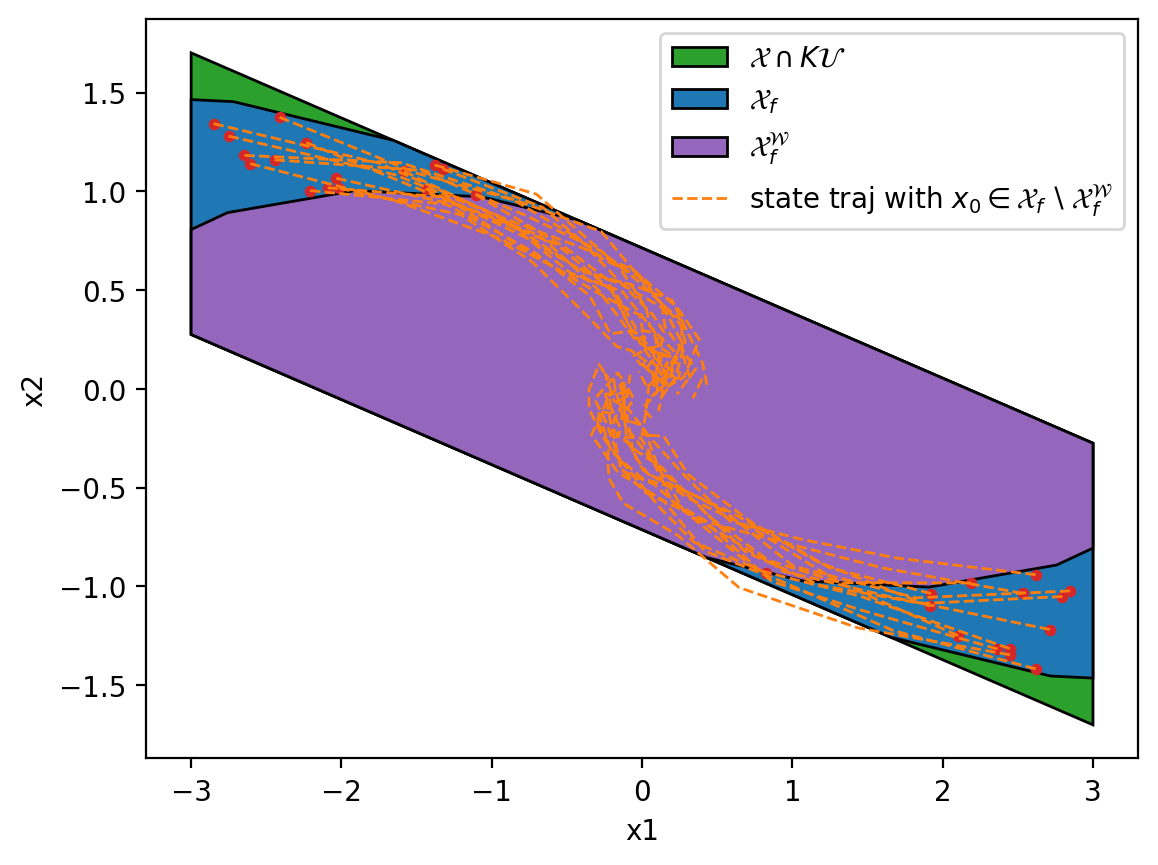

In [11]:
num_samples = 30
N_sim = 10  # simulation steps

# Plot the sets
fig, ax = plt.subplots(1, 1)
X_and_KU.plot(ax, color='tab:green', opacity=1., label=r'$\mathcal{X}\cap K\mathcal{U}$')
Xf.plot(ax, color='tab:blue', opacity=1., label=r'$\mathcal{X}_f$')
Xf_W.plot(ax, color='tab:purple', opacity=1., label=r'$\mathcal{X}^\mathcal{W}_f$')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

# TODO: ------------------
# TODO: add your code here
# Sample disturbed trajectories and plot
attempts = 0
max_attempts = 20 * num_samples
x0_samples = []
while attempts < max_attempts:
    x0 = Xf.sample(1).flatten()
    if x0 not in Xf_W:
        x0_samples.append(x0)
    attempts += 1
    if len(x0_samples) == num_samples:
        break

if len(x0_samples) < num_samples:
    raise RuntimeError(f"Failed to generate enough samples after {max_attempts} attempts. Try increasing max_attempts!")

x0_samples = np.vstack(x0_samples)

for i in range(num_samples):
    x0 = x0_samples[i]
    x_traj_2 = np.ndarray((x0.shape[0], N_sim))
    x_traj_2[:,0] = x0
    for i_sim in range(N_sim - 1):
        x_traj_2[:, i_sim + 1] = (A + B @ K) @ x_traj_2[:, i_sim] + W.sample(1).reshape((-1,))
    label=r'state traj with $x_0 \in \mathcal{X}_f \setminus \mathcal{X}_f^{\mathcal{W}}$' if i == 0 else None
    ax.plot(x_traj_2[0, :], x_traj_2[1, :], color='tab:orange', linestyle='--', linewidth=1.0, label=label)
        
ax.scatter(x0_samples[:, 0], x0_samples[:, 1], c='tab:red', s=10.)
ax.legend()
# TODO: ------------------
plt.show()